In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from google.colab import drive

import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')
import soundfile as sf

from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.layers import LSTM, Dense


# device_name = tensorflow.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [ ]:
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Splitting the Audio Files

In [ ]:
def divide(folder,output):
  general_path = '/content/drive/MyDrive/archive/Data'
  music_type = list(os.listdir(f'{general_path}/{folder}/')) 

  
  for i in music_type:
    files= list(os.listdir(f'{general_path}/{folder}/{i}'))
    for j in files:
      try: 
        y, sr = librosa.load(f'{general_path}/{folder}/{i}/{j}')
        y, _ = librosa.effects.trim(y)

        for k in range(0,len(y),(sr*3)):
          l= k+(sr*3)
          temp_audio = y[k:l]
          sf.write('/content/drive/MyDrive/archive/Data/'+output +'/'+i+ '/' +j.rstrip('.wav')+ "." +str(k)+ '.wav', temp_audio, sr)
          print('file_written: ',i,j)
      except:
        print('Skipped',i,j)

In [ ]:
# divide('genres_original','3sec')
# # divide('Augmented','Aug3sec')

# Audio Data and Feature Exploration

In [ ]:
def explore(folder):
  general_path = '/content/drive/MyDrive/archive/Data'
  i = list(os.listdir(f'{general_path}/{folder}/'))[0]
  j = list(os.listdir(f'{general_path}/{folder}/{i}'))[0]
  y, sr = librosa.load(f'{general_path}/{folder}/{i}/{j}')

  print('y:', y)
  print('y shape:', np.shape(y))
  print('Sample Rate (KHz):', sr)

  # Verify length of the audio
  print('Check Len of Audio:', len(y)/sr)

  zero_crossings = librosa.zero_crossings(y, pad=False)
  print('zero_crossings: ',sum(zero_crossings))

  y_harm, y_perc = librosa.effects.hpss(y)
  print('y_harm: ',y_harm.mean())
  print('y_perc: ',y_perc.mean())

  tempo, _ = librosa.beat.beat_track(y=y,sr=sr)
  print('tempo:', tempo)

  spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
  print('spectral_centroids mean: ',spectral_centroids.mean())
  print('spectral_centroids var: ',spectral_centroids.var())

  spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
  print('roll_off mean: ',spectral_rolloff.mean())
  print('roll_off var: ',spectral_rolloff.var())

In [ ]:
explore('genres_original')

y: [-0.06201172 -0.0647583   0.01269531 ...  0.17086792  0.18267822
  0.17208862]
y shape: (661794,)
Sample Rate (KHz): 22050
Check Len of Audio: 30.013333333333332
zero_crossings:  76667
y_harm:  -3.1355962e-06
y_perc:  -2.0445403e-05
tempo: 151.99908088235293
spectral_centroids mean:  2241.1592828907596
spectral_centroids var:  392224.65256360575
roll_off mean:  4490.771994181409
roll_off var:  1578088.652510671


# Feature Extraction

In [ ]:
hop_length = 256 #the default spacing between frames
n_fft = 128 #number of samples 

In [ ]:
def get_features(folder):
  labels=[]
  features=[]
  general_path = '/content/drive/MyDrive/archive/Data'
  music_type = list(os.listdir(f'{general_path}/{folder}/')) 
  
  for i in music_type:
    files= list(os.listdir(f'{general_path}/{folder}/{i}'))
    for j in files:

      try:
        y, sr = librosa.load(f'{general_path}/{folder}/{i}/{j}')

      
        data = np.array(librosa.feature.mfcc(y=y, n_fft=n_fft,hop_length=hop_length,n_mfcc=128)) # Change n_mfcc to 20
        
        # print(i," ",j," ",data.shape)
        if data.shape[1]==259:
          data=np.transpose(data)
          data= np.reshape(data,(1,data.shape[0],data.shape[1]))
          features.append(data)
          labels.append(i)
        # else:
        #   print("Didn't fill: ",j, " ",data.shape)

      except:
        print("Error: ",j)
        

  output=np.concatenate(features,axis=0)  
  return(np.array(output), labels)

# Normalisation of the Dataset and Factorisation of Labels


In [ ]:
def normalisation(features):
  features = np.array((features-np.mean(features)))
  features = features/np.std(features)
  return features

In [ ]:
#Factorizing labels
def factorized_lable(labels):
  a = pd.DataFrame(labels,columns=['Hello'])
  a.Hello = pd.factorize(a.Hello)[0]
  y2=list(a.Hello)
  y = np.array(y2)
  return y

In [ ]:
features_main,lable_main = get_features('3sec')
lable_main = factorized_lable(lable_main)
features_main = normalisation(features_main)

# Splitting the Main Dataset

Train Size - 70%
Val Size - 20%
Test Size -10%

In [ ]:
# Split twice to get the validation set
X_train, X_test, y_train, y_test = train_test_split(features_main, lable_main, test_size=0.1, random_state=123, stratify=lable_main)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)
#Print the shapes
X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val)

((7188, 259, 128), (999, 259, 128), (1798, 259, 128), 7188, 999, 1798)

# Modelling 

In [ ]:
def lstmmodel():
  input_shape=(259,128) # Change the second dimension according to n_mfcc
  model = tensorflow.keras.Sequential()
  model.add(LSTM(128,input_shape=input_shape,return_sequences=True))
  model.add(tensorflow.keras.layers.Dropout(0.3))
  model.add(LSTM(128,input_shape=input_shape))
  model.add(tensorflow.keras.layers.Dropout(0.3))
  model.add(Dense(64, activation='relu'))
  model.add(tensorflow.keras.layers.Dropout(0.3))
  model.add(Dense(10, activation='softmax'))
  model.summary()

  return model

In [ ]:
model = lstmmodel()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 259, 128)          131584    
                                                                 
 dropout (Dropout)           (None, 259, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                6

In [ ]:
def training(X_train,y_train,X_val,y_val,model):
  model.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=['acc'])
  history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_val, y_val), shuffle=False)
  return model,history

In [ ]:
model,history_model = training(X_train, y_train, X_val, y_val,model)

Epoch 1/50
225/225 [==============================] - 20s 37ms/step - loss: 1.9690 - acc: 0.2810 - val_loss: 1.6850 - val_acc: 0.3932
Epoch 2/50
225/225 [==============================] - 5s 24ms/step - loss: 1.7086 - acc: 0.3744 - val_loss: 1.5412 - val_acc: 0.4321
Epoch 3/50
225/225 [==============================] - 6s 25ms/step - loss: 1.5981 - acc: 0.4207 - val_loss: 1.4317 - val_acc: 0.4811
Epoch 4/50
225/225 [==============================] - 6s 25ms/step - loss: 1.6094 - acc: 0.4090 - val_loss: 1.6435 - val_acc: 0.4105
Epoch 5/50
225/225 [==============================] - 5s 23ms/step - loss: 1.5248 - acc: 0.4420 - val_loss: 1.4389 - val_acc: 0.4850
Epoch 6/50
225/225 [==============================] - 6s 27ms/step - loss: 1.4734 - acc: 0.4598 - val_loss: 1.3752 - val_acc: 0.5006
Epoch 7/50
225/225 [==============================] - 5s 23ms/step - loss: 1.4261 - acc: 0.4843 - val_loss: 1.3527 - val_acc: 0.5156
Epoch 8/50
225/225 [==============================] - 6s 27ms/step -

In [ ]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
def graph(history):

  history_dict=history.history
  loss_values=history_dict['loss']
  acc_values=history_dict['acc']
  val_loss_values = history_dict['val_loss']
  val_acc_values=history_dict['val_acc']
  epochs=range(1,51)
  fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
  ax1.plot(epochs,loss_values,'co',label='Training Loss')
  ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
  ax1.set_title('Training and validation loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend()
  ax2.plot(epochs,acc_values,'co', label='Training accuracy')
  ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
  ax2.set_title('Training and validation accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.legend()
  plt.show()

In [ ]:
graph(history_model)


In [ ]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tensorflow.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

32/32 [==============================] - 1s 10ms/step
Confusion_matrix:  tf.Tensor(
[[81  0  0  4  0  1 10  2  0  2]
 [ 0 86  1  0  0  4  4  0  1  4]
 [ 0  6 64  9  1  7  0  1  7  5]
 [ 4  0  2 69  2  0  6  6  5  6]
 [ 0  0  1  6 88  0  1  0  4  0]
 [ 3  0  2  2  0 78  9  5  1  0]
 [11  0  0  2  0  3 84  0  0  0]
 [ 2  1  0  1  0  6 15 71  3  1]
 [ 0  1  6 11  8  0  0  3 69  1]
 [ 3  5  4 19  2  0 27  4  0 36]], shape=(10, 10), dtype=int32)


# TRAINING ON AUMENTED DATA

In [ ]:
explore('Augmented')

y: [-0.00682434 -0.01903095 -0.0313269  ...  0.10167041  0.06604026
  0.03721765]
y shape: (90317,)
Sample Rate (KHz): 22050
Check Len of Audio: 4.096009070294785
zero_crossings:  9493
y_harm:  0.00024877946
y_perc:  0.0030191494
tempo: 117.45383522727273
spectral_centroids mean:  2095.364910941915
spectral_centroids var:  7114.088592029369
roll_off mean:  4865.895623675848
roll_off var:  24118.788470416468


In [ ]:
# FEature Extraction of Augmented Audio
feature_augmented,lable_augmented = get_features('Aug3sec')
lable_augmented = factorized_lable(lable_augmented)
feature_augmented = normalisation(feature_augmented)


In [ ]:
# Train-Val Split for augmented Data
X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(feature_augmented,lable_augmented, test_size=0.2, random_state=123, stratify=lable_augmented)
X_train_aug.shape, X_val_aug.shape, len(y_train_aug), len(y_val_aug)

((400, 259, 128), (100, 259, 128), 400, 100)

In [ ]:
model_aug,history_model_aug = training(X_train_aug,y_train_aug, X_val_aug, y_val_aug,model)

Epoch 1/50
13/13 [==============================] - 11s 179ms/step - loss: 2.3563 - acc: 0.1425 - val_loss: 2.3061 - val_acc: 0.1000
Epoch 2/50
13/13 [==============================] - 1s 51ms/step - loss: 2.3250 - acc: 0.0725 - val_loss: 2.3009 - val_acc: 0.1300
Epoch 3/50
13/13 [==============================] - 1s 48ms/step - loss: 2.3041 - acc: 0.1050 - val_loss: 2.3039 - val_acc: 0.1000
Epoch 4/50
13/13 [==============================] - 1s 55ms/step - loss: 2.3292 - acc: 0.0850 - val_loss: 2.2965 - val_acc: 0.1000
Epoch 5/50
13/13 [==============================] - 1s 54ms/step - loss: 2.3182 - acc: 0.0925 - val_loss: 2.2964 - val_acc: 0.1000
Epoch 6/50
13/13 [==============================] - 1s 52ms/step - loss: 2.3148 - acc: 0.1000 - val_loss: 2.2963 - val_acc: 0.1200
Epoch 7/50
13/13 [==============================] - 1s 66ms/step - loss: 2.3021 - acc: 0.1125 - val_loss: 2.2897 - val_acc: 0.1300
Epoch 8/50
13/13 [==============================] - 1s 39ms/step - loss: 2.2893 -

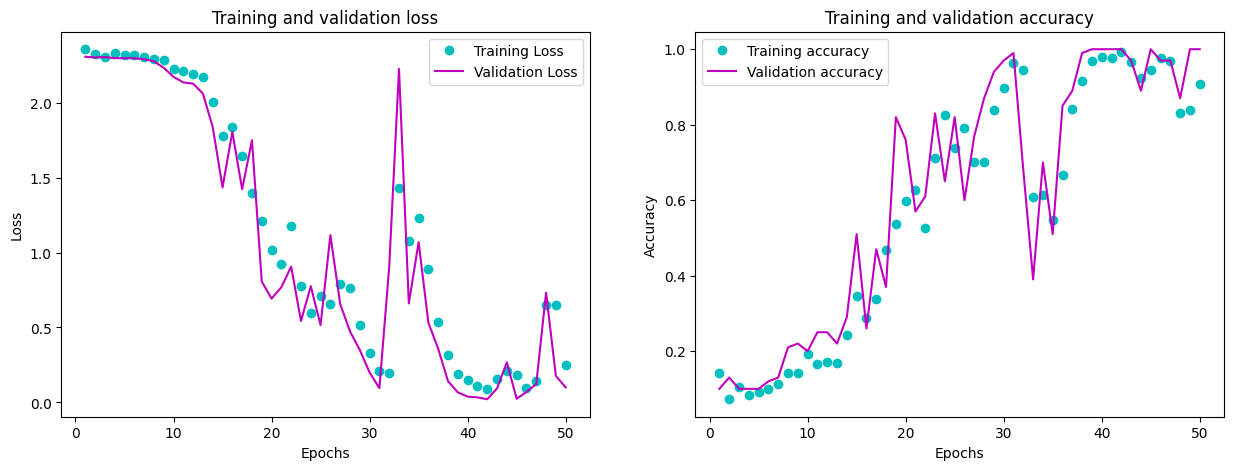

In [ ]:
graph(history_model_aug)

In [ ]:
TrainLoss, Trainacc = model_aug.evaluate(X_train_aug,y_train_aug)
TestLoss, Testacc = model_aug.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tensorflow.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

32/32 [==============================] - 1s 9ms/step
Confusion_matrix:  tf.Tensor(
[[ 0  1  0 37  2 16  0 43  0  1]
 [ 1  3  0  9 26 28  4 21  7  1]
 [ 1  6  0 40  7 13  1 29  1  2]
 [ 0  2  0 60  1 16  0 21  0  0]
 [ 1 12  1 74  2  1  3  2  1  3]
 [ 0  1  0 29  7 30  3 23  6  1]
 [ 0  1  4 25  7 24  5 28  3  3]
 [ 0  3  0 40  6 19  0 26  4  2]
 [ 0  2  1 56  0 12  1 25  1  1]
 [ 1  7  1 37  7 18  5 17  4  3]], shape=(10, 10), dtype=int32)
